# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [5]:
(x_train, y_train), (x_test, y_test)= tfutils.datasets.mnist.load_data(one_hot=False)
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_train = tfutils.datasets.mnist.load_subset([0], x_test, y_test)
x = np.concatenate([x_train, x_test], axis=0)

<IPython.core.display.Javascript object>


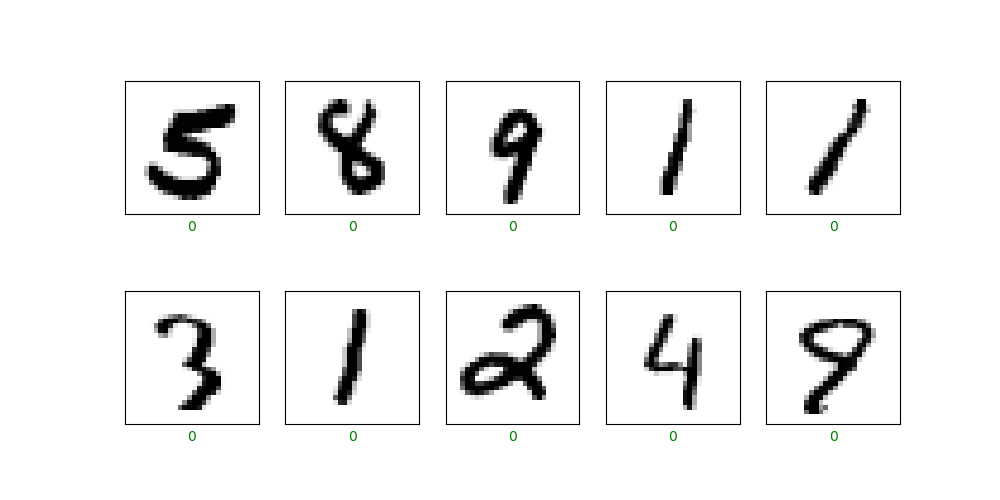

In [8]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0],1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [16]:
discriminator = Sequential([Conv2D(64,3, strides=2, input_shape=(28,28,1)),
                           LeakyReLU(),BatchNormalization(),
                            Conv2D(128, 5, strides=2), 
                           LeakyReLU(),BatchNormalization(), 
                            Conv2D(256,5, strides=2),
                           LeakyReLU(),BatchNormalization(), 
                            Flatten(),
                            Dense(1, activation='sigmoid')
                           ])
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 256)        

# Task 4: Generator

In [19]:
generator = Sequential([
    Dense(256, activation= 'relu', input_shape=(1, )),
    Reshape((1,1,256)),
    
    Conv2DTranspose(256,5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128,5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64,5,strides=2, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32,5, activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4,)
])
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


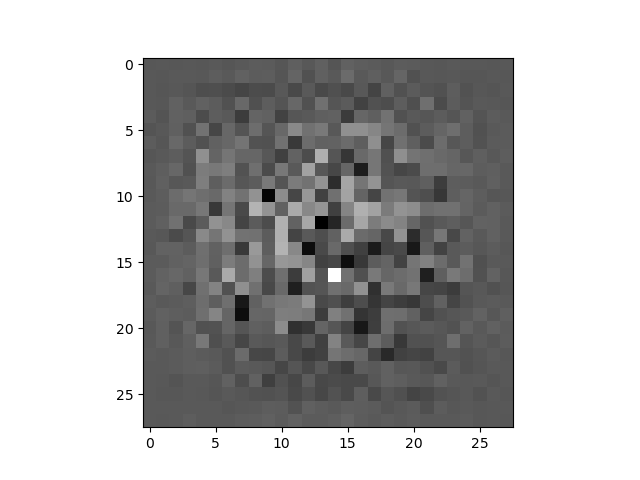

In [24]:
noise = np.random.randn(1,1)
gen_image= generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap= 'binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [27]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan= Model(input_layer, disc_out)

discriminator.trainable = False
gan.compile(loss ='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [28]:
epochs=25
batch_size = 128
steps_per_epoch = int(2*x.shape[0]/batch_size)


<IPython.core.display.Javascript object>


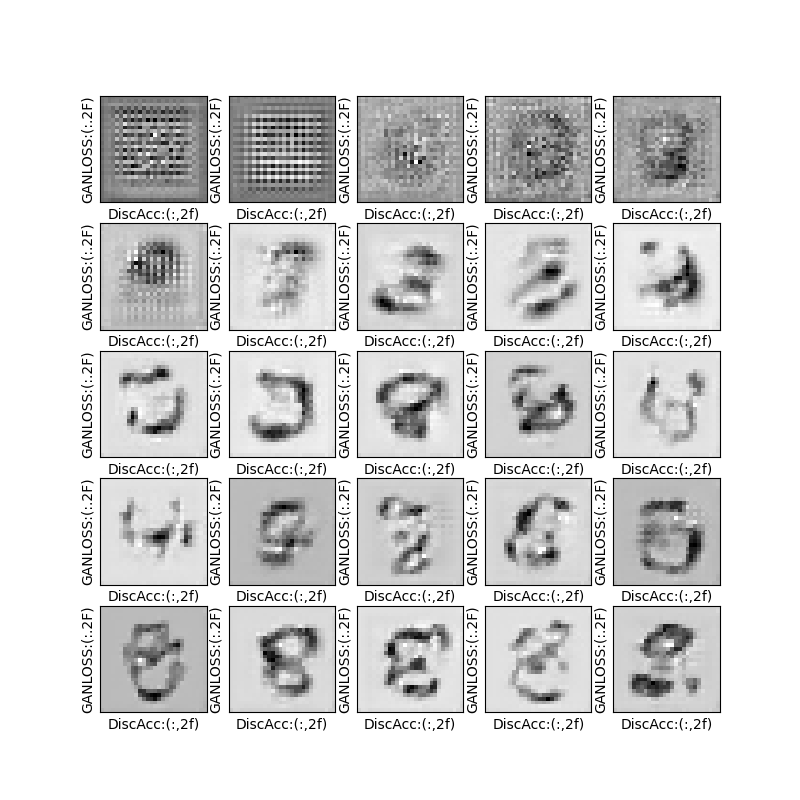

In [36]:
dp= tfutils.plotting.DynamicPlot(plt, 5, 5, (8,8))

for e in range(0,epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2*step):int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        noise = np.random.randn(int(batch_size/2), 1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*int(batch_size/2) +[1]* int(batch_size/2))
        
        indices= np.random.choice(range(batch_size), batch_size, replace= False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose= False)
        
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28, 28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc:(:,2f)'.format(acc), 'GANLOSS:(:.2F)'.format(loss))
        